<a href="https://colab.research.google.com/github/vortexash/Tensorflow-Developer/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about new kind of transfer learning: fine-tuning

In [1]:
# Check if we're using a GPU
!nvidia-smi

Thu Nov  4 16:36:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebook we've create a bunch of helper functions, now we could rewrite them all,however,this is tedious.

So, it's a good idea to put functions we'll want to use again in ascript we can download and import into our notebooks(or elsewhere).

We've done this for some of the functions we've using previously https://raw.githubusercontent.com/vortexash/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/vortexash/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-04 16:36:25--  https://raw.githubusercontent.com/vortexash/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-04 16:36:25 (74.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper function we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If we're running this notebook in google colab, when it times out colab will delete `helper_functions.py`, so you'll have to re-download it if we want to access ti our helper functions.

## Let's get some data

This time we're are going to see how we can use the pre-trained models within tf.keras.applications and apply then to our own problem (recognizing images of food).

link:https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
unzip_data("10_food_classes_10_percent.zip")

--2021-11-04 16:36:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   171MB/s    in 0.9s    

2021-11-04 16:36:29 (171 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and sub-directories are in our dataset
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_10_perc

In [6]:
# Create and training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode = 'categorical',
                                                                           batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                               image_size = IMG_SIZE,
                                                               label_mode = 'categorical',
                                                               batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# Check out the class names of the dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# Seeing an example of a batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)


tf.Tensor(
[[[[7.87142792e+01 7.87142792e+01 5.47142868e+01]
   [7.83316345e+01 7.77346954e+01 5.55255127e+01]
   [7.81428528e+01 7.71428528e+01 5.75714302e+01]
   ...
   [9.30765228e+01 8.35050507e+01 7.32907867e+01]
   [9.60969543e+01 8.20969543e+01 7.30969543e+01]
   [1.01484741e+02 8.44847412e+01 7.64847412e+01]]

  [[8.10204086e+01 7.80255127e+01 5.53571434e+01]
   [7.90000000e+01 7.70000000e+01 5.60000000e+01]
   [7.73724442e+01 7.46020355e+01 5.78724480e+01]
   ...
   [9.55153503e+01 8.31581421e+01 7.39438782e+01]
   [9.78622437e+01 8.38622437e+01 7.48622437e+01]
   [1.00954086e+02 8.39540863e+01 7.59540863e+01]]

  [[8.42193832e+01 7.71428528e+01 5.81428566e+01]
   [8.18571396e+01 7.67142868e+01 5.77857132e+01]
   [7.99081573e+01 7.61887741e+01 6.20000000e+01]
   ...
   [9.95714722e+01 8.59081726e+01 7.47398224e+01]
   [1.01198975e+02 8.71989746e+01 7.61989746e+01]
   [1.01494888e+02 8.51377487e+01 7.53520355e+01]]

  ...

  [[1.19790871e+02 1.16500084e+02 1.09862366e+02]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it euns layers in sequential order.

But the functional API gives more flexibility with our models.
https://www.tensorflow.org/guide/keras/functional

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained  aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using model like ResNet50v2 we will need to normalize inputs(you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

# 5. Pass the input to the base_model
x = base_model(inputs)
print(f" Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "gobal_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape} ")

# 7. Create the output  activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])
# 10. Fit our model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                  epochs=5, 
                                  steps_per_epoch =len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps= int(0.25 * len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
 Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280) 
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20211104-163641
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 47s 468ms/step - loss: 1.9355 - accuracy: 0.3560 - val_loss: 1.3555 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 7s 264ms/step - loss: 1.1587 - accuracy: 0.7600 - val_loss: 0.9109 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - 9s 355ms/step - loss: 0.8510 - accuracy: 0.8120 - val_loss: 0.7497 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 9s 352ms/step - loss: 0.6861 - accuracy: 0.8440 - val_loss: 0.6373 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 9s 352ms/step - loss: 0.5913 - accuracy: 0.8640 - val_loss: 0.5933 - val_accuracy: 0.8421


In [12]:
# Evaluate on the ful test data
model_0.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.6110 - accuracy: 0.8416


[0.6109752655029297, 0.8416000008583069]

In [13]:
# Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
# How about we get summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [15]:
# How about a summary of our model
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
gobal_average_pooling_layer  (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


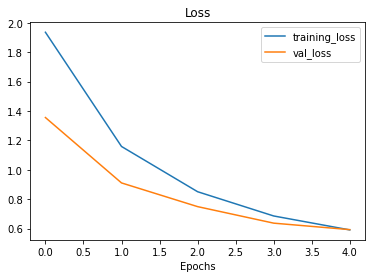

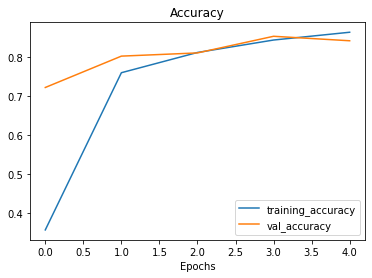

In [16]:
# Check out our model's training curve
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model 

Let's demonstrate the Gobal Average Pooling 2D layer..

WE have a tensor after our model goes through `base_model` of shape (None, 7,7,1280).

But then whet it passes  through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GobalAveragePooling2D.

In [17]:
# Define the input shape
input_shape =(1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor =tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tenosr through a gobal average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D  global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the differerent tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"shape of Global Average Pooled 2D tensor:{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D  global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
shape of Global Average Pooled 2D tensor:(1, 3)


In [18]:
# Let's replicate the GobalAveragePoole2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice** Try to do the same with the above two cells but this time use `GobalMaxPool2D`..and see what happens.

**Note:** One of the reasins feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layer.GobalAveragePooled2D()` layer) which can then be used to extract patterns out of for own specific problem.

## Running a series of transfer learning experiments

We've have seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.

2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation

3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.

4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

**Note:** Throughout all experiments the same test dataset will be used to evaluate our model.. this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [19]:
# Download and unzip data - preprocess fro Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-11-04 16:38:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   189MB/s    in 0.7s    

2021-11-04 16:38:20 (189 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Creatinf training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'

In [22]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size= BATCH_SIZE) # default = 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size= BATCH_SIZE) # default = 32

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our model, we can use layers inside:

* `tf.keras.layers.experimental.preprocessing()`

we can see the benifits of doing this within the Tensorfow Data augmentation documentation:https://www.tensorflow.org/tutorials/images/data_augmentation

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmentating them)happens on the GPU (much faster) rrather the CPU

* Image data augmentation only happens during training, so we can still export our modle and use it elsewhere.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing. RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation")

### Visualise our data augmentation layer (and see what happens to our data)

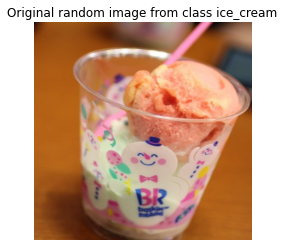

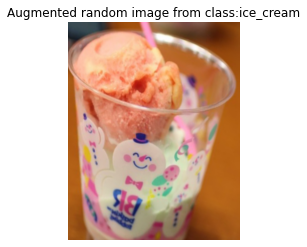

In [26]:
# View a random image and comapre it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class:{target_class}")
plt.axis(False);

In [25]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 1: Feautre extraction Transfer Learning on 1% of the data with data augmentation

In [34]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

#Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_mosel the inputs (after augmentation) and don't train it

x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a Ddense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# make a model using the inputs and outputs
model_1 =  keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20211104-171742
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 15s 3s/step - loss: 2.4264 - accuracy: 0.1000 - val_loss: 2.2086 - val_accuracy: 0.2138
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1467 - accuracy: 0.2000 - val_loss: 2.1072 - val_accuracy: 0.2796
Epoch 3/5
3/3 [==============================] - 6s 3s/step - loss: 1.9344 - accuracy: 0.3571 - val_loss: 2.0078 - val_accuracy: 0.3388
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8346 - accuracy: 0.4571 - val_loss: 1.9063 - val_accuracy: 0.3980
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6480 - accuracy: 0.6571 - val_loss: 1.8254 - val_accuracy: 0.4457


In [35]:
# Check out outr modle summary
model_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [36]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 128ms/step - loss: 1.8259 - accuracy: 0.4420


[1.825850248336792, 0.44200000166893005]

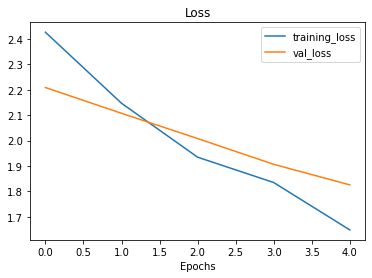

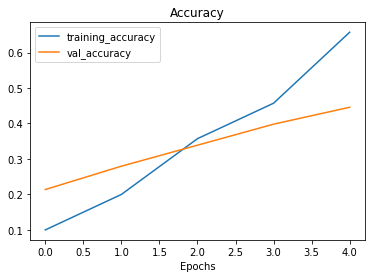

In [37]:
# How do the model with 1% of the and data augmentation loss curves look? 
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learing with 10% of data and data augmentation

In [41]:
# Get 10% of data
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [43]:
#  How many images are in our directories?
walk_through_dir(train_dir_10_percent)

There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.


In [53]:
# Set data inputs
import tensorflow as tf
IMG_SIZE =(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [54]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescale(1./255), If your are using model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling built in.
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224,224, 3)

# Create a frozen model(also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment out training images (augmentation doesn't occure on test data)
x = base_model(x, training=False) # We pass the augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Create a ModelCheckpoint Callback

The modelCheckpoint callback intermediately saves out model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [56]:
 # Set checkpoint path

 checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

 # Create a ModelCheckpoint callback that saves the model's weight only
 checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                    save_weights_only=True,
                                                                    save_best_only=False,
                                                                    save_freq="epoch", #save every epoch
                                                                    verbose=1)

In [57]:
# fit the model 2 passing in the ModelCheckpoint callback
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211104-180609
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 25s 726ms/step - loss: 2.0743 - accuracy: 0.3080 - val_loss: 1.5242 - val_accuracy: 0.6447

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 14s 572ms/step - loss: 1.3995 - accuracy: 0.6480 - val_loss: 1.0774 - val_accuracy: 0.7599

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 16s 642ms/step - loss: 1.1112 - accuracy: 0.7013 - val_loss: 0.8948 - val_accuracy: 0.7862

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 14s 545ms/step - loss: 0.9372 - accuracy: 0.7733 - val_loss: 0.7851 - val_accuracy: 0.7928

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 13s 507ms/step - loss: 0.8160 - accuracy: 0.7893 - val_

In [58]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 11s 129ms/step - loss: 0.6110 - accuracy: 0.8416


[0.6109752655029297, 0.8416000008583069]

In [60]:
# Check model_2 results on all test_data
result_10_percent_data_aug = model_2.evaluate(test_data)
result_10_percent_data_aug

79/79 [==============================] - 11s 130ms/step - loss: 0.7010 - accuracy: 0.8180


[0.7010380625724792, 0.8180000185966492]

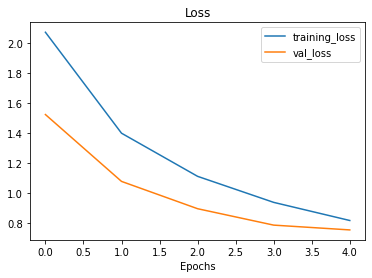

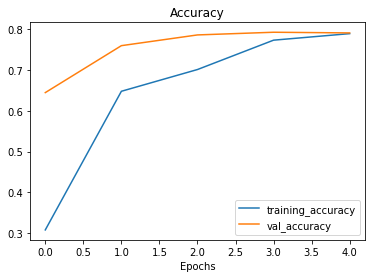

In [61]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)